In [1]:
import glob

import regex as re
import numpy as np
from pathlib import Path

rg = f'Finished epoch (\d*) in \d+:(\d+):\d+, average epoch triplet loss = (\d+.\d+)\\n\d+-\d+-\d+ \d+:\d+:\d+   Recalls on val set < BaseDataset, pitts30k - #database: \d+; #queries: \d+ >: R@1: (\d*.\d), R@5: (\d*.\d), R@10: (\d*.\d), R@20: (\d*.\d)'
rargs = f'[\w_]+=\[[\d ,]+\]|[\w_]+=[^, )]+'

In [2]:
filedepth = glob.glob('./*/*/*')
res = []
for d in filedepth:
    if d.split('\\')[-1] == 'info.log':
        with open(d) as fil:
            text = ''.join(fil.readlines())
            result = re.findall(rg, text, re.MULTILINE)
            args = re.findall(rargs, text)
            if result:
                arg_dic = {a.split('=')[0]: a.split('=')[1] for a in args}
                result = np.array([tuple(map(float, r)) for r in result])
                exp_name = Path(d).parent.parent.name
                res.append((arg_dic, result, exp_name))

### NetVlad Analysis

In [21]:
import pandas as pd
netvlad_data = list(filter(lambda x: x[2] == 'NetVlad_abl' and x[0]['netvlad_clusters'] != 'None', res))
netvlad_data_last = [(data[0]['netvlad_clusters'], data[0]['lr'], data[1][-1,4], data[1][-1, 2]) for data in netvlad_data]
netvlad_data_last = pd.DataFrame(netvlad_data_last, columns=['Netvlad Clusters', 'Learning Rate', 'R5 on val set', 'Last loss value'])

In [22]:
netvlad_data_last

,Netvlad Clusters,Learning Rate,R5 on val set,Last loss value
0,64,0.0001,81.3,0.0592
1,64,1e-05,34.0,0.0980
2,64,1e-05,43.8,0.0964
3,64,1e-06,25.0,0.0997
4,32,1e-06,36.9,0.1003
5,32,1e-05,75.3,0.0962
6,32,0.0001,88.4,0.0390
7,16,1e-05,83.2,0.0939
8,16,0.0001,80.7,0.0865
9,16,1e-06,72.7,0.0981


We can see that lower number of clusters and higher learning rate tend to give better results, the higher learning rate could be an effect of training for only 20 epochs

In [11]:
loss_data = [(el[1][:, [0, 2]], el[0]['netvlad_clusters']) for el in netvlad_data]

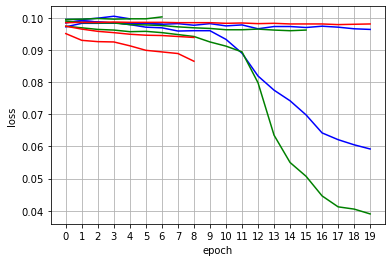

In [19]:
import matplotlib.pyplot as plt
plt.xticks(range(20))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
color = {'16': 'r', '32': 'g', '64': 'b'}
for data in loss_data:
    plt.plot(data[0][:, 0], data[0][:, 1], color[data[1]])

We can see that loss values highly depend on the learning rate, the lower number of clusters brings high loss values
but also good recall values with a very low number of epochs, this means that for high scoring training we can use
higher number of kernels while for 'good enough' trainings that are time-constrained we can use a low number of
kernels
For now the best model found is 32 clusters with learning rate 1e-4

### GeM Analysis

In [24]:
gem_data = list(filter(lambda x: x[2] == 'GeM_Ablation_Tests' and x[0]['gem_power'] != 'None', res))

### Alternative Optimizers analys

In [26]:
sdg_data = list(filter(lambda x: x[2] == 'NetVlad_sdg', res))